In [1]:
import os
import sys
from sys import platform
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns

# Add the parent directory to the sys.path (without this we cannot import constants or scripts)
sys.path.insert(0, str(Path.cwd().parent))
from src.plotting import plot_comparison_GER_HIC_GLO
from constants.countries import highincome_countries
from src.utils import get_iso3_gbd, generate_high_income_global_avg_index

%load_ext autoreload

In [2]:
import matplotlib.pyplot as plt 

from tueplots import bundles

In [3]:
# if platform == 'darwin': # macos
#     print('mac os')
#     os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [4]:
DATA_PATH = '../data/final'
OUTPUT_PATH = '../doc/IHD_germany_2024/fig'
cvd_data_path = f'{DATA_PATH}/gbd_cardiovascular_allAges_final.csv'
YEAR_COLUMN_NAME = 'year'
VALUE_COLUMN_NAME = 'val'

## Load Data

In [5]:
df = pd.read_csv(cvd_data_path)
df = df[df.measure_name=='Deaths']
df['country_code'] = df['location_name'].map(get_iso3_gbd)

In [6]:
df = df[['location_name', 'country_code', 'year', 'val']]
df.columns = ['Country Name', 'Country Code', 'Year', 'IHD']

In [7]:
df['Country Code'].nunique()

204

In [8]:
year_cols = [str(i) for i in range(1960, 2023)]

In [9]:
health_df = pd.read_csv('../data/raw/health_expenditure.csv')
health_df = health_df.melt(id_vars=['Country Name', 'Country Code'], value_vars=year_cols, var_name='Year', value_name='HealthInd')
health_df['Year'] = health_df['Year'].astype(int)
health_df = health_df.drop(['Country Name'], axis=1)
health_df = health_df.dropna()

In [10]:
health_df.dropna()['Country Code'].nunique()

238

In [11]:
# health_df = pd.read_csv(DATA_PATH+'/oecd_combined_final.csv')
# health_df = health_df.rename({'Value': 'HealthInd'}, axis=1).drop(['Country Name', 'Series Name'], axis=1)

In [12]:
fat_df = pd.read_csv(DATA_PATH+'/daily_per_capita_fat_supply_final.csv')
fat_df = fat_df.rename({'Value': 'Fat'}, axis=1).drop(['Country Name', 'Series Name'], axis=1)

In [13]:
alc_df = pd.read_csv(DATA_PATH+'/wdi_AlcoholConsumption.csv')
alc_df = alc_df.rename({'Value': 'Alcohol'}, axis=1).drop(['Country Name', 'Series Name'], axis=1)

In [14]:
age_df = pd.read_csv('../data/raw/median-age.csv')
age_df = age_df[['Code', 'Year', 'Median age - Sex: all - Age: all - Variant: estimates']]
age_df.columns = ['Country Code', 'Year', 'Age']

In [15]:
final_df = df.merge(health_df, on=['Country Code', 'Year'])
final_df = final_df.merge(alc_df, on=['Country Code', 'Year'])
# final_df = final_df.merge(fat_df, on=['Country Code', 'Year'])
final_df = final_df.merge(age_df, on=['Country Code', 'Year'])

In [16]:
final_df

,Country Name,Country Code,Year,IHD,HealthInd,Alcohol,Age
0,Samoa,WSM,2000,0.368311,4.396606,4.04168,18.5
1,Samoa,WSM,2000,237.006361,4.396606,4.04168,18.5
2,Austria,AUT,2000,0.473877,9.203713,12.89070,37.1
3,Austria,AUT,2000,452.709757,9.203713,12.89070,37.1
4,Vanuatu,VUT,2000,0.317660,3.306833,1.26851,17.0
...,...,...,...,...,...,...,...
1791,Cyprus,CYP,2019,236.959544,6.949430,8.05289,36.6
1792,Belarus,BLR,2019,0.619024,5.861338,10.90107,39.7
1793,Belarus,BLR,2019,792.975384,5.861338,10.90107,39.7
1794,Sweden,SWE,2019,0.384713,10.832243,9.29617,39.6


In [17]:
mean_df = final_df.groupby(['Country Name', 'Country Code'])[['IHD', 'HealthInd', 'Alcohol', 'Age']].last().reset_index()

In [18]:
%autoreload 2
mean_df = generate_high_income_global_avg_index(mean_df, value_cols=['IHD', 'HealthInd', 'Alcohol', 'Age'], year_col=None)

In [19]:
# mean_df[mean_df['Is High Income']]

In [20]:
from src.plotting import bubble_plot_factors_and_rates

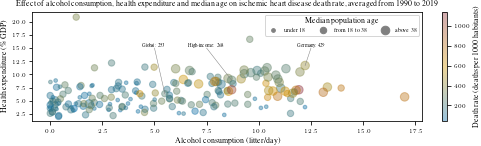

In [21]:
%autoreload 2

output_fig_path = OUTPUT_PATH + '/fig_bubble_plot_factors.pdf'
bubble_plot_factors_and_rates(mean_df, x_col='Alcohol', y_col='HealthInd', size_col='Age', hue_col='IHD',
                            x_label='Alcohol consumption (litter/day)', y_label='Health expenditure (\\% GDP)',
                            size_label='Median population age', hue_label='Death rate (deaths per 1000 habitants)',
                            country_col='Country Name',
                            title='Effect of alcohol consumption, health expenditure and median age on ischemic heart disease death rate, averaged from 1990 to 2019',
                            output_path=output_fig_path)